In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sn
import random
plt.close('all')

In [2]:
queries = pd.read_csv('new_logs.csv', index_col="idx", dtype={"AnonID": "Int64", "Query": "string", "QueryTime": "string", "ItemRank": "Int32", "ClickURL": "string", "Type": "string", "SessionNum": "Int32"})


In [3]:
group_by_sessions = queries.groupby('AnonID', sort=False, as_index=False)
qqq = group_by_sessions.max(numeric_only=True)
newIDs = qqq.loc[qqq['SessionNum'] >= 19]
print(newIDs)
# print(newIDs["AnonID"])

         AnonID  SessionNum  ItemRank
0         91602         286       189
1       2846780         192        40
2       1750999         363       364
3        118401         322       119
4        186465         159       182
...         ...         ...       ...
53028  18287420          30      <NA>
53643   3962900          23        35
54960   1466736          20         1
63748   7213879          26         5
64443  16419908          25         1

[15665 rows x 3 columns]


In [4]:
# Tokenize into sessions
# print(newIDs)
# sessions = []

# for i in range(len(newIDs[0:5])):
#   max_sessions = newIDs.iloc[i]["SessionNum"]
#   anonId = newIDs["i"]["AnonID"]
#   for j in max_sessions:

## Compute edit distance with LCS
def cost(action):
  if action["Type"] == "Query":
    return 1
  elif action["Type"] == "Click":
    return 1
  elif action["Type"] == "NextPage":
    return 1

def compute_distance_lcs(seqA, seqB):
  sizeA = len(seqA) + 1
  sizeB = len(seqB) + 1

  matrix = np.zeros((sizeA, sizeB))
  for x in range(sizeA):
    for y in range(sizeB):
      if x == 0 or y == 0:
        matrix[x, y] = 0
      elif seqA.iloc[x-1]["Type"] == seqB.iloc[y-1]["Type"]:
        matrix[x, y] = matrix[x-1, y-1] + 1
      else:
        matrix[x, y] = max(matrix[x-1, y], matrix[x, y-1])

  LCS_len = matrix[sizeA - 1, sizeB - 1]

  def backtrack(x, y):
    if x == 0 or y == 0:
      return []
    elif seqA.iloc[x-1]["Type"] == seqB.iloc[y-1]["Type"]:
      return backtrack(x-1, y-1) + [seqA.iloc[x - 1]]
    elif matrix[x, y-1] > matrix[x-1, y]:
      return backtrack(x, y-1)
    else:
      return backtrack(x-1, y)

  LCS = backtrack(sizeA - 1, sizeB - 1)

  cost_A = 0
  cost_B = 0
  cost_LCS = 0

  for x in range(sizeA - 1):
    cost_A += cost(seqA.iloc[x])

  for y in range(sizeB - 1):
    cost_B += cost(seqB.iloc[y])

  for s in LCS:
    cost_LCS += cost(s)

  return (cost_A + cost_B - 2 * cost_LCS)
  

# seqA = queries.loc[(queries["AnonID"] == newIDs.iat[0, 0]) & (queries["SessionNum"] == 12)]
# seqB = queries.loc[(queries["AnonID"] == newIDs.iat[25, 0]) & (queries["SessionNum"] == 17)]
# print("SEQ_A")
# print(seqA)

# print("SEQ_B")
# print(seqB)
# print(compute_distance_lcs(seqA, seqB))


In [5]:
## Randomly sample 5,000 sessions

### First, create all possible tuples
tuples = []
# for idx, row in newIDs.iterrows():
#   tuples += [(row["AnonID"], i) for i in range(row["SessionNum"])]

## First, extract all tuples with appropriately long sessions

ssss = queries.groupby(["AnonID", "SessionNum"]).count()
ss = ssss[ssss["Query"] >= 5]

for idx, _ in ss.iterrows():
  tuples += [idx]

### Then, draw 5,000 samples

SAMPLE_SIZE = 50

sample = random.sample(tuples, SAMPLE_SIZE)

distances = np.zeros((SAMPLE_SIZE, SAMPLE_SIZE))

for i in range(SAMPLE_SIZE):
  for j in range(i):
    seqA = queries.loc[(queries["AnonID"] == sample[i][0]) & (queries["SessionNum"] == sample[i][1])]
    seqB = queries.loc[(queries["AnonID"] == sample[j][0]) & (queries["SessionNum"] == sample[j][1])]
    distances[i,j] = compute_distance_lcs(seqA, seqB)
    distances[j, i] = distances[i, j]


<AxesSubplot:>

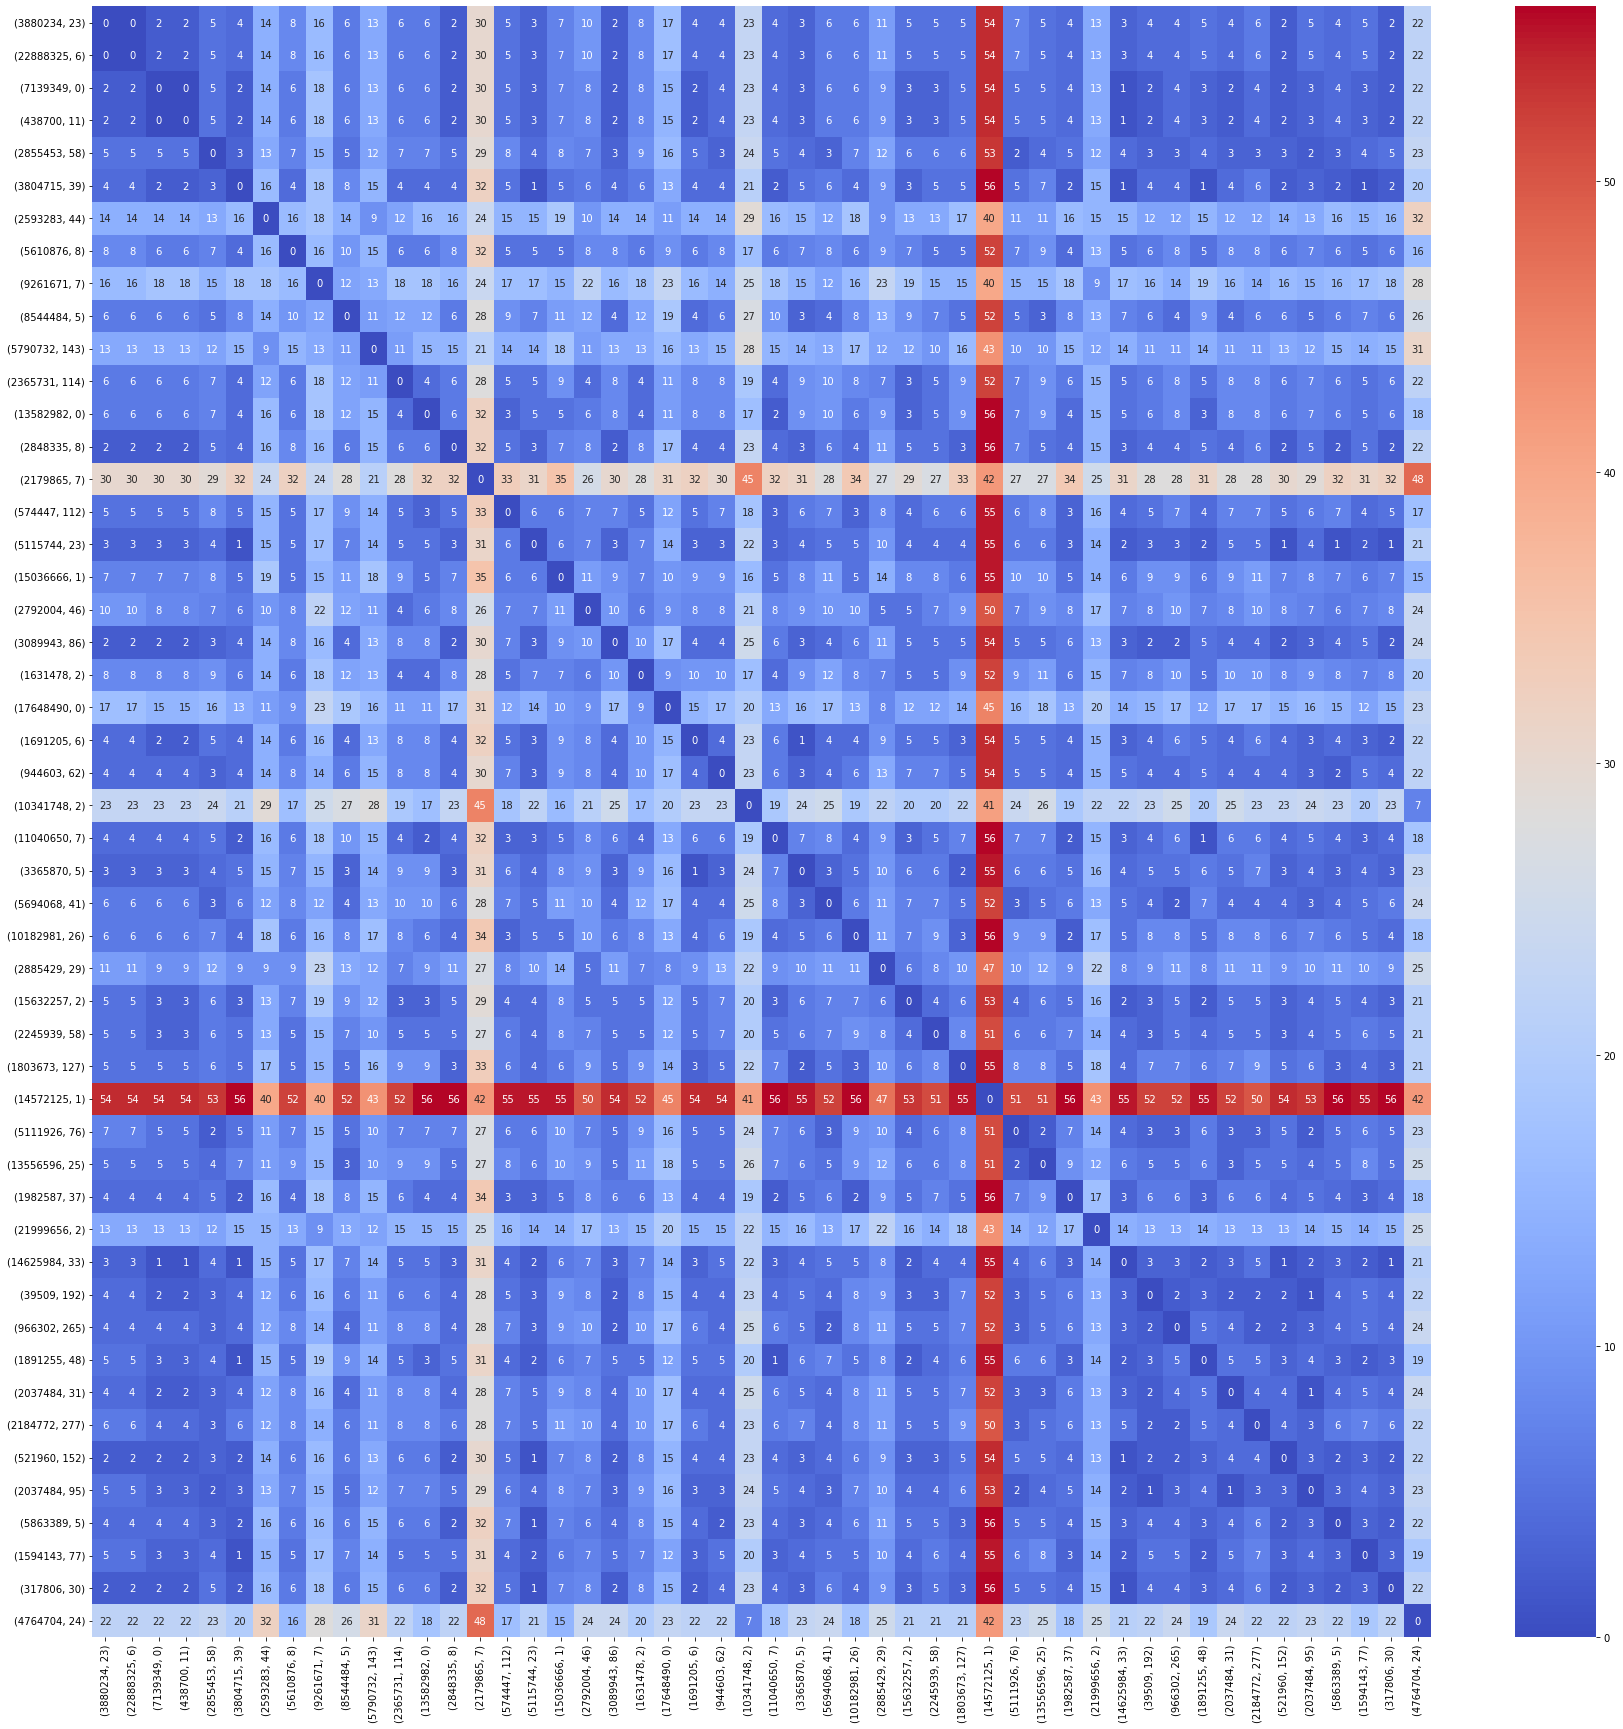

In [6]:
from sklearn.cluster import AgglomerativeClustering

c = AgglomerativeClustering(n_clusters = None, affinity="precomputed", distance_threshold=0.2, compute_full_tree = True, linkage="average")

labels = c.fit_predict(distances)

idx = np.argsort(labels)
sorted_sample = [sample[x] for x in idx]

distances_df = pd.DataFrame(data=distances, index=labels, columns = labels).sort_index(axis=0).sort_index(axis=1)
distances_df.set_axis(sorted_sample, axis="index", inplace=True)
distances_df.set_axis(sorted_sample, axis="columns", inplace=True)

plt.figure(figsize= (30, 30))
sn.heatmap(distances_df, annot=True,  cmap="coolwarm")

In [25]:
q4 = queries[(queries["AnonID"] == sorted_sample[7][0]) & (queries["SessionNum"] == sorted_sample[7][1])]
print(sorted_sample[7], q4)

(7689628, 0)           AnonID                     Query            QueryTime   Type  \
idx                                                                      
3140621  7689628             dog kenneling  2006-03-04 16:12:10  Query   
3140622  7689628             dog kenneling  2006-03-04 16:12:10  Click   
3140623  7689628  tips on kenneling my dog  2006-03-04 16:17:13  Query   
3140624  7689628  tips on kenneling my dog  2006-03-04 16:17:13  Click   
3140625  7689628  tips on kenneling my dog  2006-03-04 16:17:13  Click   

         SessionNum  ItemRank                          ClickURL  
idx                                                              
3140621           0      <NA>                              <NA>  
3140622           0         9        http://www.workingdogs.com  
3140623           0      <NA>                              <NA>  
3140624           0         1  http://www.dogtrainingbasics.com  
3140625           0        10              http://e.webring.com  


              Query     QueryTime          Type      ItemRank      ClickURL
count  1.068907e+06  1.068907e+06  1.068907e+06  1.068907e+06  1.068907e+06
mean   4.379920e+00  4.380083e+00  4.380083e+00  1.755562e+00  1.755562e+00
std    5.878897e+00  5.878814e+00  5.878814e+00  3.085260e+00  3.085260e+00
min    0.000000e+00  1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00
25%    2.000000e+00  2.000000e+00  2.000000e+00  0.000000e+00  0.000000e+00
50%    2.000000e+00  2.000000e+00  2.000000e+00  1.000000e+00  1.000000e+00
75%    5.000000e+00  5.000000e+00  5.000000e+00  2.000000e+00  2.000000e+00
max    1.000000e+02  1.000000e+02  1.000000e+02  8.900000e+01  8.900000e+01


<AxesSubplot:>

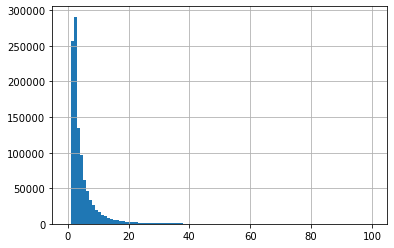

In [12]:
ssss = queries.groupby(["AnonID", "SessionNum"]).count()
ssssss = ssss[ssss["Query"] <= 100]
print(ssssss.describe())
ssssss["Query"].hist(bins=100)

